# Importing and Transforming Data

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from chord import Chord
pd.set_option('precision', 3)

In [2]:
! pwd

/Users/jenniferzhan/ao3-vizzes/ATLA


In [3]:
df_in = pd.read_csv('atla_fics_1205_full_mod.csv')

#dropping duplicate rows in case the the scraping was restarted at the wrong place
df_in = df_in.drop_duplicates()

df_in.head()

,work_id,title,relationship,published,words,kudos
0,27896395,Owner of My Heart (Little Pieces),Katara/Zuko (Avatar),2020-12-05,415.0,32.0
1,27896272,What Started In Beautiful Rooms,Sokka/Zuko (Avatar),2020-12-05,878.0,35.0
2,25574854,The Dragon of the South,"Other Relationship Tags to Be Added, Sokka/Zuk...",2020-07-28,66045.0,595.0
3,26838538,Conflagration,"Katara/Zuko (Avatar), Katara & Zuko (Avatar), ...",2020-10-05,54904.0,81.0
4,27896089,Barely Disguised,Mai/Ty Lee (Avatar),2020-12-05,1648.0,7.0


In [4]:
df_in.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21207 entries, 0 to 21704
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   work_id       21207 non-null  int64  
 1   title         21207 non-null  object 
 2   relationship  17713 non-null  object 
 3   published     21207 non-null  object 
 4   words         21201 non-null  float64
 5   kudos         21008 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.1+ MB


In [6]:
#clean up and add new columns
df_edit = df_in.copy()

for col in ['relationship']:
    df_edit[col] = df_edit[col].str.replace('Toph Bei Fong','Toph Beifong')
    df_edit[col] = df_edit[col].str.replace('Original Female Character','OFC')
    df_edit[col] = df_edit[col].str.replace('Original Male Character','OMC')

df_edit['published'] = pd.to_datetime(df_edit['published'], format='%Y-%m-%d')
df_edit['published_year'] = pd.DatetimeIndex(df_edit['published']).year
df_edit['pub_date_yr_month'] = df_edit['published'].dt.strftime('%Y-%m')
df_edit['contains_rs_ship'] = np.where((df_edit['relationship'].str.contains('/')) & ~(df_edit['relationship'].isnull()), 1, 0)
df_edit['kudos'] = df_edit['kudos'].fillna(0)

In [7]:
df_edit.describe()

,work_id,words,kudos,published_year,contains_rs_ship
count,2.121e+04,2.120e+04,21207.000,21207.000,21207.000
mean,1.828e+07,9.565e+03,269.797,2017.943,0.701
std,9.806e+06,3.987e+04,714.945,3.093,0.458
min,8.000e+00,0.000e+00,0.000,2005.000,0.000
25%,9.705e+06,1.055e+03,29.000,2017.000,0.000
50%,2.410e+07,2.380e+03,79.000,2020.000,1.000
75%,2.606e+07,6.376e+03,218.000,2020.000,1.000
max,2.792e+07,2.441e+06,24584.000,2020.000,1.000


In [8]:
#Aggregate by month published to see fics published over time 
agg = {'work_id':'count', 'relationship':'count'}

df_date = (df_edit.groupby(['pub_date_yr_month'])[['work_id','relationship']].agg(agg)
          ).rename(columns={'work_id':'total_works', 'relationship':'total_works_with_relationship'})

df_date['total_gen_fics'] = df_date['total_works'] - df_date['total_works_with_relationship']
df_date['pct_gen_fics'] = df_date['total_gen_fics'] / df_date['total_works']

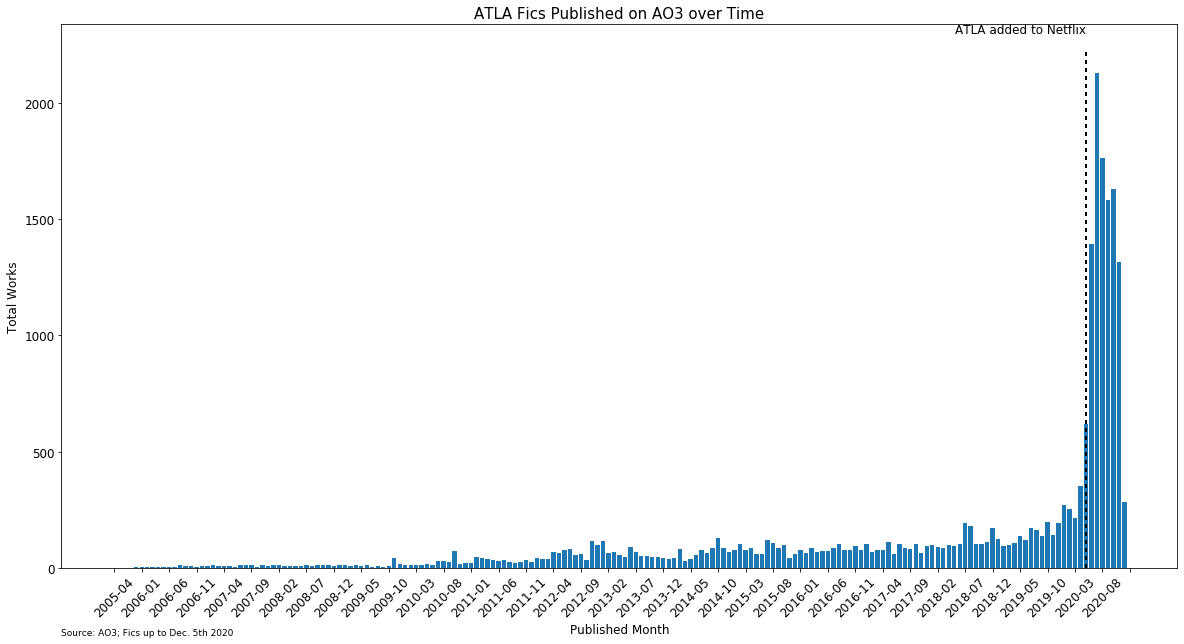

In [9]:
plt.figure(figsize=(20, 10))
x = df_date.index
y = df_date['total_works']
plt.bar(x, y)
plt.plot(['2020-05', '2020-05'], [0, y.max()+100], 'k-', lw=2,dashes=[2, 2])
plt.text('2020-05',2300,'ATLA added to Netflix', horizontalalignment='right', fontsize=12)
plt.xticks(np.arange(0, len(x)+1, 5), rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Published Month', fontsize=12)
plt.ylabel('Total Works', fontsize=12)
plt.title('ATLA Fics Published on AO3 over Time', fontsize=15)
plt.annotate('Source: AO3; Fics up to Dec. 5th 2020', (0,0), (0, -60), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=9)
plt.savefig('atla_fics_over_time.png')

plt.show()

/Users/jenniferzhan/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/jenniferzhan/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/jenniferzhan/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


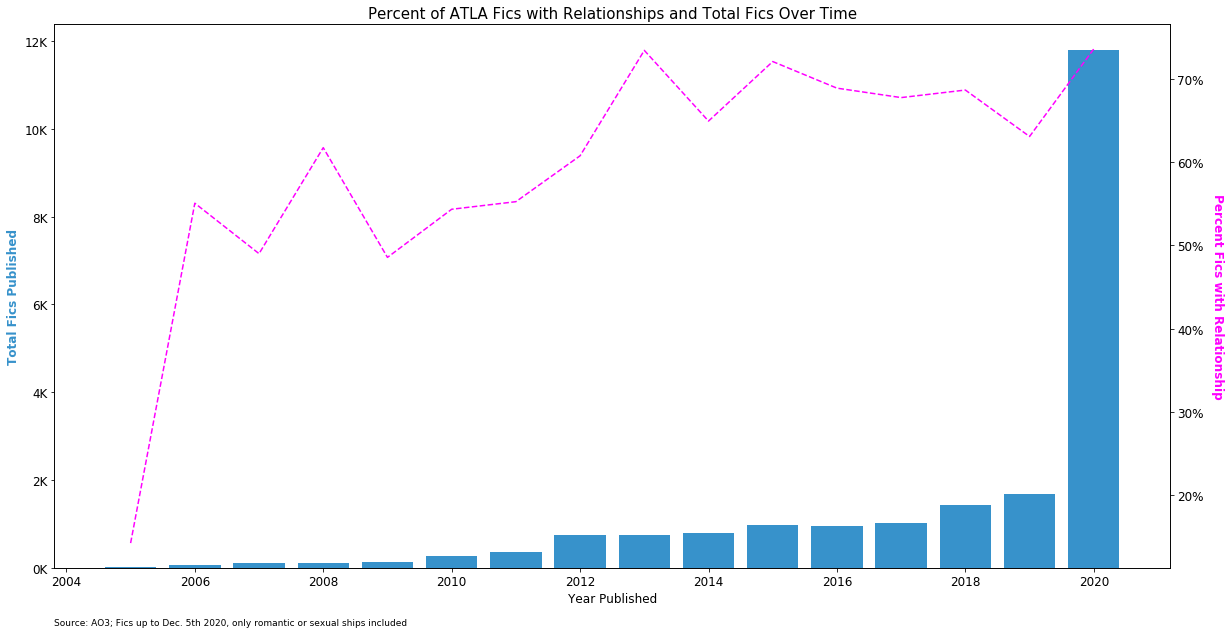

In [15]:
#Aggregate by year to see fics published and percent with relationship over time 
agg = {'work_id':'count', 'relationship':'count', 'words':'mean', 'contains_rs_ship':'sum'}
col_date = list(agg.keys())

df_date = (df_edit.groupby(['published_year'])[col_date].agg(agg)
          ).rename(columns={'work_id':'total_works'
                            , 'relationship':'total_works_with_any_relationship'
                            , 'contains_rs_ship':'total_works_with_romantic_or_sexual_relationship'
                            , 'words':'average_words'})

df_date['pct_any_relationship_fics'] = df_date['total_works_with_any_relationship'] / df_date['total_works']
df_date['pct_rs_relationship_fics'] = df_date['total_works_with_romantic_or_sexual_relationship'] / df_date['total_works']

x = df_date.index
y1 = df_date['pct_rs_relationship_fics']
y2 = df_date['total_works']

f, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title('Percent of ATLA Fics with Relationships and Total Fics Over Time', fontsize=15)
ax2 = ax1.twinx()
ax1.bar(x, y2, color='#3792cb', width=0.8)
ax2.plot(x, y1, '--', color='magenta')
ax1.set_xlabel('Year Published', fontsize=12)

ax1.set_ylabel('Total Fics Published', color='#3792cb', fontweight='bold', fontsize=12)
ax2.set_ylabel('Percent Fics with Relationship', color='magenta', fontweight='bold', rotation=270, labelpad=20, fontsize=12)

ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1))  
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: '{:,.0f}'.format(x/1000) + 'K'))
plt.xticks(fontsize=12)
ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)
#ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.0f}' + 'K'))

plt.annotate('Source: AO3; Fics up to Dec. 5th 2020, only romantic or sexual ships included', (0,0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=9)

plt.savefig('atla_pct_ship_over_time.png')
plt.show()

In [16]:
#Filtering only for fics that have at least one tagged relationship
df_with_r = df_edit.loc[~df_edit.relationship.isna()].copy()

In [17]:
df_with_r.count()

work_id              17713
title                17713
relationship         17713
published            17713
words                17707
kudos                17713
published_year       17713
pub_date_yr_month    17713
contains_rs_ship     17713
dtype: int64

In [21]:
df_with_r['Zuko/Sokka'] = np.where(df_with_r['relationship'].str.contains('Sokka/Zuko') 
                                   | df_with_r['relationship'].str.contains('Zuko/Sokka'), 1, 0)

df_with_r['Zuko/Katara'] = np.where(df_with_r['relationship'].str.contains('Katara/Zuko') 
                                   | df_with_r['relationship'].str.contains('Zuko/Katara'), 1, 0)

df_with_r['Katara/Aang'] = np.where(df_with_r['relationship'].str.contains('Katara/Aang') 
                                   | df_with_r['relationship'].str.contains('Aang/Katara'), 1, 0)

agg = {'Zuko/Sokka':'sum', 'Zuko/Katara':'sum', 'work_id':'nunique', 'Katara/Aang':'sum'}

df_fam = df_with_r.groupby(['published_year']).agg(agg).rename(columns={'work_id':'total_works'})

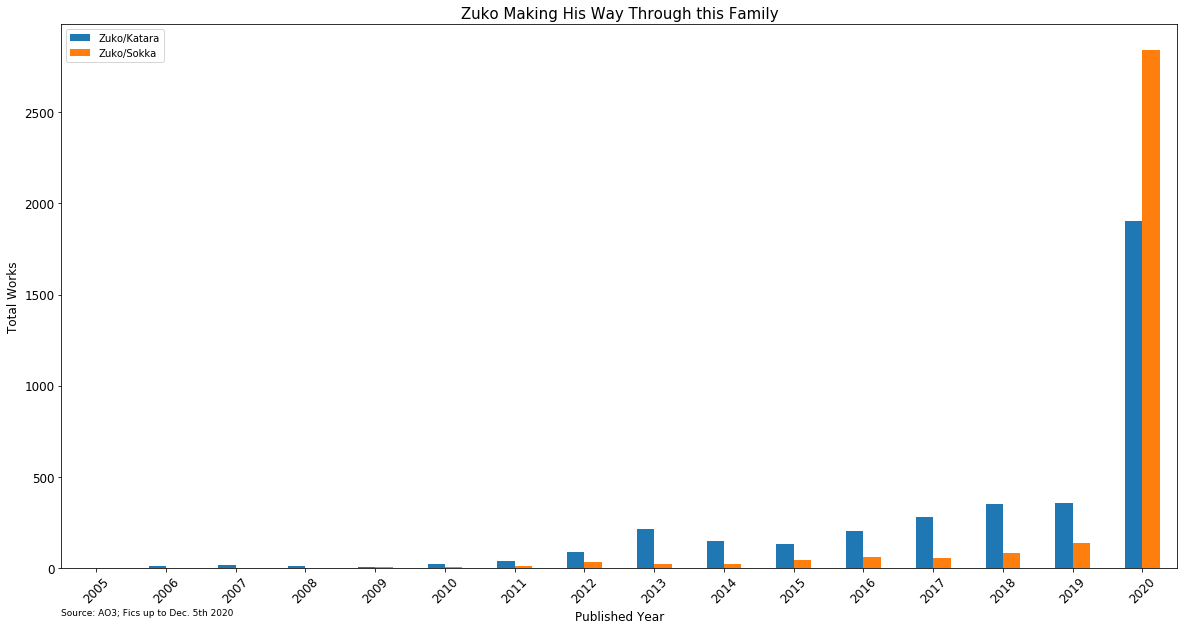

In [23]:
ax = df_fam[['Zuko/Katara', 'Zuko/Sokka']].plot(kind='bar')
fig = ax.get_figure()
fig.set_size_inches(20,10)
plt.title('Zuko Making His Way Through this Family', fontsize=15)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Published Year', fontsize=12)
plt.ylabel('Total Works', fontsize=12)
plt.annotate('Source: AO3; Fics up to Dec. 5th 2020', (0,0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=9)
plt.savefig('Zuko_Fam.png')

plt.show()

In [24]:
#split out multiple ships in one fic
df_r = df_with_r.relationship.str.split(',', expand=True)

#joins back to original df
df_r2 = pd.concat([df_with_r[['work_id', 'published_year', 'kudos', 'words']], df_r], axis = 1)
df_r2.head()

,work_id,published_year,kudos,words,0,1,2,3,4,5,...,71,72,73,74,75,76,77,78,79,80
0,27896395,2020,32.0,415.0,Katara/Zuko (Avatar),None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,27896272,2020,35.0,878.0,Sokka/Zuko (Avatar),None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,25574854,2020,595.0,66045.0,Other Relationship Tags to Be Added,Sokka/Zuko (Avatar),Minor or Background Relationship(s),None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,26838538,2020,81.0,54904.0,Katara/Zuko (Avatar),Katara & Zuko (Avatar),Suki/Ty Lee (Avatar),Aang/Katara (Avatar) temporarily,Mai & Zuko (Avatar) temporarily,None,...,None,None,None,None,None,None,None,None,None,None
4,27896089,2020,7.0,1648.0,Mai/Ty Lee (Avatar),None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [25]:
#unpivot by relationship for easy data cleaning 
df_long = pd.melt(df_r2, id_vars = ['work_id', 'published_year', 'kudos', 'words'], var_name = 'relationship_number', value_name = 'ship')
df_long.head()

,work_id,published_year,kudos,words,relationship_number,ship
0,27896395,2020,32.0,415.0,0,Katara/Zuko (Avatar)
1,27896272,2020,35.0,878.0,0,Sokka/Zuko (Avatar)
2,25574854,2020,595.0,66045.0,0,Other Relationship Tags to Be Added
3,26838538,2020,81.0,54904.0,0,Katara/Zuko (Avatar)
4,27896089,2020,7.0,1648.0,0,Mai/Ty Lee (Avatar)


In [26]:
#drop rows where ship is null (since unpivot creates a row for rel_2, rel_40 even if fic only has one ship)
df_long = df_long.dropna(subset = ['ship']).copy()
df_long['relationship_number'] =  df_long['relationship_number'] + 1 
df_long.head()

,work_id,published_year,kudos,words,relationship_number,ship
0,27896395,2020,32.0,415.0,1,Katara/Zuko (Avatar)
1,27896272,2020,35.0,878.0,1,Sokka/Zuko (Avatar)
2,25574854,2020,595.0,66045.0,1,Other Relationship Tags to Be Added
3,26838538,2020,81.0,54904.0,1,Katara/Zuko (Avatar)
4,27896089,2020,7.0,1648.0,1,Mai/Ty Lee (Avatar)


In [28]:
#For inspecting what percent of fic have X ships or fewer 
ct_rel_num = df_long.groupby('work_id')[['relationship_number']].max().reset_index()

pct_rel_num = ct_rel_num.groupby('relationship_number')[['work_id']].nunique().rename(columns={'work_id':'total_works'})
pct_rel_num['pct_total_fics'] = pct_rel_num['total_works'] / pct_rel_num['total_works'].sum().round(3)
pct_rel_num['cum_sum_pct'] = pct_rel_num['pct_total_fics'].cumsum()

pct_rel_num.head(11)

,total_works,pct_total_fics,cum_sum_pct
relationship_number,,,
1,9284,0.528,0.528
2,3378,0.192,0.721
3,1804,0.103,0.823
4,1180,0.067,0.890
5,639,0.036,0.927
6,414,0.024,0.950
7,243,0.014,0.964
8,163,0.009,0.973
9,124,0.007,0.980


In [29]:
#split out ship into the characters
#note that I am only looking at romantic ships right now--platonic denoted by & will be discarded
df_char = df_long.ship.str.split('/', expand=True)
df_char = df_char.add_prefix('char_')

#joins back to original df
df_long_2 = pd.concat([df_long, df_char], axis = 1)
df_long_2.head()

,work_id,published_year,kudos,words,relationship_number,ship,char_0,char_1,char_2,char_3,char_4,char_5,char_6,char_7
0,27896395,2020,32.0,415.0,1,Katara/Zuko (Avatar),Katara,Zuko (Avatar),None,None,None,None,None,None
1,27896272,2020,35.0,878.0,1,Sokka/Zuko (Avatar),Sokka,Zuko (Avatar),None,None,None,None,None,None
2,25574854,2020,595.0,66045.0,1,Other Relationship Tags to Be Added,Other Relationship Tags to Be Added,None,None,None,None,None,None,None
3,26838538,2020,81.0,54904.0,1,Katara/Zuko (Avatar),Katara,Zuko (Avatar),None,None,None,None,None,None
4,27896089,2020,7.0,1648.0,1,Mai/Ty Lee (Avatar),Mai,Ty Lee (Avatar),None,None,None,None,None,None


In [30]:
#Removing extra spaces and the name of the media at the end of the character
#(e.g., ' Sokka (Avatar)' becomes 'Sokka')
for col in [col for col in df_long_2.columns if col.startswith('char')]:
    df_long_2[col] = df_long_2[col].str.strip()
    df_long_2[col] = df_long_2[col].str.replace(' \(.+\)', '')
    
df_long_2.head()

,work_id,published_year,kudos,words,relationship_number,ship,char_0,char_1,char_2,char_3,char_4,char_5,char_6,char_7
0,27896395,2020,32.0,415.0,1,Katara/Zuko (Avatar),Katara,Zuko,None,None,None,None,None,None
1,27896272,2020,35.0,878.0,1,Sokka/Zuko (Avatar),Sokka,Zuko,None,None,None,None,None,None
2,25574854,2020,595.0,66045.0,1,Other Relationship Tags to Be Added,Other Relationship Tags to Be Added,None,None,None,None,None,None,None
3,26838538,2020,81.0,54904.0,1,Katara/Zuko (Avatar),Katara,Zuko,None,None,None,None,None,None
4,27896089,2020,7.0,1648.0,1,Mai/Ty Lee (Avatar),Mai,Ty Lee,None,None,None,None,None,None


In [31]:
#Removing the rows without a second character (either gen ship or poorly tagged rs ship)
df_long_2 = df_long_2.dropna(subset=['char_1']).reset_index()
df_long_2.head()

,index,work_id,published_year,kudos,words,relationship_number,ship,char_0,char_1,char_2,char_3,char_4,char_5,char_6,char_7
0,0,27896395,2020,32.0,415.0,1,Katara/Zuko (Avatar),Katara,Zuko,None,None,None,None,None,None
1,1,27896272,2020,35.0,878.0,1,Sokka/Zuko (Avatar),Sokka,Zuko,None,None,None,None,None,None
2,3,26838538,2020,81.0,54904.0,1,Katara/Zuko (Avatar),Katara,Zuko,None,None,None,None,None,None
3,4,27896089,2020,7.0,1648.0,1,Mai/Ty Lee (Avatar),Mai,Ty Lee,None,None,None,None,None,None
4,5,27857221,2020,0.0,7549.0,1,Nara Shikadai /Yue,Nara Shikadai,Yue,None,None,None,None,None,None


In [32]:
#Inspect some 3+ character pairings 
df_copy = df_long_2.copy()
df_copy.loc[~df_copy['char_3'].isna()].head()

,index,work_id,published_year,kudos,words,relationship_number,ship,char_0,char_1,char_2,char_3,char_4,char_5,char_6,char_7
3993,5247,24165247,2020,41.0,4788.0,1,Azula/Korra/Ty Lee/Asami Sato,Azula,Korra,Ty Lee,Asami Sato,None,None,None,None
4077,5376,24701011,2020,174.0,36217.0,1,Suki/Sokka/Zuko/Mai/Ty Lee,Suki,Sokka,Zuko,Mai,Ty Lee,None,None,None
6565,8627,8202484,2016,185.0,86632.0,1,Uzumaki Naruto/Azula Uzumaki Naruto/Mai Uzumak...,Uzumaki Naruto,Azula Uzumaki Naruto,Mai Uzumaki Naruto,Ty Lee Uzumaki Naruto,June,None,None,None
7400,9586,2201790,2014,53.0,445.0,1,Aang/Katara/Mai/Zuko (Avatar),Aang,Katara,Mai,Zuko,None,None,None,None
8193,10488,388054,2012,38.0,516.0,1,Water/Earth/Fire/Air,Water,Earth,Fire,Air,None,None,None,None


In [33]:
#Columns to loop through 

char_col = [col for col in df_copy.columns if ('char' in col)]
#Remove the last item on the list because we don't need to loop through it 
char_col.pop()
other_col = [col for col in df_copy.columns if not('char' in col)]

In [34]:
#Loop through the pairings with more than two characters and create new rows for each two-person combo 

long_df_list = []
finished_col = []

for col in char_col:
    df_final_copy1 = (df_copy.drop(columns=finished_col)
                      .set_index(other_col + [col])
                      .stack().to_frame().reset_index()
                      .rename(columns={col:'char_a', 0:'char_b'})
                     )
    finished_col.append(col)
    long_df_list.append(df_final_copy1)

df_final = pd.concat(long_df_list)

In [35]:
#Check a fic with an OT3
df_final.loc[df_final['work_id'] == 24701011]

,index,work_id,published_year,kudos,words,relationship_number,ship,char_a,level_8,char_b
4142,5376,24701011,2020,174.0,36217.0,1,Suki/Sokka/Zuko/Mai/Ty Lee,Suki,char_1,Sokka
4143,5376,24701011,2020,174.0,36217.0,1,Suki/Sokka/Zuko/Mai/Ty Lee,Suki,char_2,Zuko
4144,5376,24701011,2020,174.0,36217.0,1,Suki/Sokka/Zuko/Mai/Ty Lee,Suki,char_3,Mai
4145,5376,24701011,2020,174.0,36217.0,1,Suki/Sokka/Zuko/Mai/Ty Lee,Suki,char_4,Ty Lee
15533,23089,24701011,2020,174.0,36217.0,2,Sokka/Suki (Avatar),Sokka,char_1,Suki
19569,40802,24701011,2020,174.0,36217.0,3,Sokka/Zuko (Avatar),Sokka,char_1,Zuko
21876,58515,24701011,2020,174.0,36217.0,4,Mai/Zuko (Avatar),Mai,char_1,Zuko
23241,76228,24701011,2020,174.0,36217.0,5,Mai/Ty Lee (Avatar),Mai,char_1,Ty Lee
24000,93941,24701011,2020,174.0,36217.0,6,Suki/Ty Lee (Avatar),Suki,char_1,Ty Lee
24511,111654,24701011,2020,174.0,36217.0,7,Sokka/Suki/Zuko (Avatar),Sokka,char_1,Suki


In [44]:
#For transforming the data into the input for the chord chart 
def create_matrix(data_input
                  , max_rel_num=1
                  , max_pub_year=df_final['published_year'].max()
                  , min_pub_year=df_final['published_year'].min()
                  , min_num_kudos=0
                  , min_num_fics=10 
                  , min_num_words=1
                  , max_num_words=df_final['words'].max()
                  ):    

    #filter the dataframe based on relationship number, published period, and min kudos
    df_final_1 = data_input.loc[(data_input['relationship_number'] <= max_rel_num) 
                              & (data_input['published_year'] >= min_pub_year)
                              & (data_input['published_year'] <= max_pub_year)
                              & (data_input['kudos'] >= min_num_kudos)
                              & (data_input['words'] >= min_num_words)
                              & (data_input['words'] <= max_num_words)
                             ].copy()
    
    total_num_fics = df_final_1['work_id'].nunique()
    
    #Getting combinations of Char 0 and Char 1
    cooccurrence = pd.crosstab(index=[df_final_1['char_a']], columns=[df_final_1['char_b']])
    #Getting total list of unique characters
    chars = np.unique(df_final_1[['char_a', 'char_b']].values)
    #Reindexing so both rows and columns contain all characters
    cooccurrence = cooccurrence.reindex(index=chars, columns=chars)
    #Making it symmetrical 
    cooccurrence = cooccurrence.add(cooccurrence.T, fill_value=0)
    #Replacing NAs with 0s 
    cooccurrence = cooccurrence.fillna(0)
    
    #Check the accuracy of the matrix 
    check_1a = len(df_final_1.loc[((df_final_1['char_a'] == 'Zuko')& (df_final_1['char_b'] == 'Katara'))
               |((df_final_1['char_a'] == 'Katara')& (df_final_1['char_b'] == 'Zuko'))])
    check_1b = cooccurrence.Zuko['Katara']
    check_1c = cooccurrence.Katara['Zuko']

    if check_1a == check_1b == check_1c:
        print(f'The matrix is correct.\n')
    else: 
        print(f'Something went wrong with the matrix.\n')
    
    max_fics = cooccurrence.max().max()
    print(f'The most popular pairing has {max_fics} fics.\n')
    
    #For filtering for ships that have at least N fics
    cooccur_f = cooccurrence.copy()

    #Set pairings with fewer than N fics to zero
    cooccur_f[cooccur_f <= min_num_fics] = 0
    #Then filter out rows and columns that sum to zero (i.e., character does not pair with any other more than 5 times)
    cooccur_f = cooccur_f.loc[(cooccur_f.sum(axis=1) != 0), (cooccur_f.sum(axis=0) != 0)]
    
    #Set what matrix we want to try 
    matrix = cooccur_f

    #Get list of characters for chord labels
    names = list(matrix.columns)
    values = matrix.values.tolist()
    num_char = len(names)
    
    if min_num_words > 1000:
        min_num_words_f = str(round(min_num_words / 1000, 1)) + 'K'
    else:
        min_num_words_f = str(round(min_num_words, 0))
        
    if max_num_words > 1000:
        max_num_words_f = str(round(max_num_words / 1000, 1)) + 'K'
    else:
        max_num_words_f = str(round(max_num_words, 0))
    
    print(f'This chart encompasses {total_num_fics} fics published on AO3 between {min_pub_year} and {max_pub_year}, between {min_num_words_f} and {max_num_words_f} words long, and with {min_num_kudos} kudos')
    print(f'It examines pairings with at least {min_num_fics} occurrences.') 
    print(f'Only the top {max_rel_num} tagged ships per fic are included. There are {num_char} characters in this chart.\n')

    chart = Chord(values, names
                  , margin = 40
                  , width = 600
                  , colors="d3.schemeSet3"
                  , opacity=0.8
                  , font_size="10px"
                  , font_size_large="15px"
                  , padding=0.03
                 )
    
    chart.show()
    return names, values, chart

In [45]:
names_2020, values_2020, chart_2020 = create_matrix(df_final, 
                              max_rel_num = 2,
                              min_num_fics = 50, 
                              max_pub_year = 2020)

The matrix is correct.

The most popular pairing has 3660.0 fics.

This chart encompasses 14335 fics published on AO3 between 2005 and 2020, between 1 and 2441.0K words long, and with 0 kudos
It examines pairings with at least 50 occurrences.
Only the top 2 tagged ships per fic are included. There are 24 characters in this chart.



In [159]:
chart_2020.to_html('atla_2020.html')

In [53]:
names_20202, values_20202, chart_20202 = create_matrix(df_final,
                                                        max_rel_num = 2,
                                                        min_num_fics = 50, 
                                                        max_pub_year = 2020,
                                                        min_num_kudos = 50,
                                                        #min_num_words = 5000,
                                                        max_num_words = 5000
                                                      )

The matrix is correct.

The most popular pairing has 1697.0 fics.

This chart encompasses 5846 fics published on AO3 between 2005 and 2020, between 1 and 5.0K words long, and with 50 kudos
It examines pairings with at least 50 occurrences.
Only the top 2 tagged ships per fic are included. There are 17 characters in this chart.

